# This Notebook 
In this notebook we will familirize ourselves with the Wavelet Transform Analysis Code from [Torrence and Compo (1998)](https://github.com/ct6502/wavelets). We will explore the results of the wavelet transform, the effects of Gaussian noise on the data, and how to test significance in Wavelet Power. 

## Morlet Wavelet:
1. Shape:<br>
The Morlet wavelet is like a little wave, a bit like a sine wave. It's like a smooth oscillating wave with a bell-shaped curve
2. Frequency Representation:<br>
One cool thing about the Morlet wavelet is that it's for a specific frequency. This means it's good at representing signals that have a similar frequency. Imagine it as a tool that's really good at catching certain musical notes in a song.

3. Application:<br>
Because of its frequency sensitivity, the Morlet wavelet is often used in analyzing signals that have both high and low-frequency components. It's like having a versatile tool that can pick up on various aspects of a signal.
- It is often used for analyzing signals that have both high and low-frequency components.
- Suitable for capturing oscillatory patterns in a signal.

## Paul Wavelet:
1. Shape: <br>
The Paul wavelet is a bit different. It has a more concentrated oscillation compared to the Morlet wavelet. Instead of a smooth curve, it has a more spiky appearance.

2. Frequency Representation:<br>
The Paul wavelet is also frequency-specific, but it's particularly good for representing signals with sharp changes. It's like a tool that's excellent at capturing sudden shifts or edges in a signal.

3. Application:<br>
Researchers often use the Paul wavelet when they are interested in signals that have abrupt changes or sharp features. For example, if you were analyzing a signal that represented sudden jumps in temperature or stock prices, the Paul wavelet might be a good choice.
- Well-suited for representing signals with abrupt changes or sharp features.
- Useful when analyzing signals with sudden jumps or edges.

## In Simple Terms:<br>
Think of the Morlet wavelet as a smooth tool that's good at capturing different musical notes in a song, and the Paul wavelet as a spiky tool that's great for catching sudden changes or jumps in a signal. Each wavelet has its own strengths, and scientists choose between them based on the specific characteristics of the signals they are studying. It's like having different tools in a toolbox, each designed for a specific job.

# Functions

## Import Functions 

In [1]:
# Importing necesary modules
import sys
import os
import glob 
import copy
import json
from os import listdir
from os import path

# Working with arrays 
import numpy as np
from scipy.fft import fftfreq

# plotting and drawing modules 
from matplotlib import pyplot as plt
import matplotlib as mpl

# import the wavelet functions
sys.path.append('/Users/veronicaestrada/Downloads/Kazachenko_Lab/Project2/wavelets/wave_python')
import waveletFunctions as waveF
#import waveletFunctions as waveF
__author__ = 'Evgeniya Predybaylo'


## Defined Functions

In [2]:
def global_to_local_siglvl(siglvl, Mother, Npoints, dj, gws=1): 
    """
    parameters:

    siglvl: The global significance level.
    Mother: The type of wavelet ('MORLET' or 'PAUL').
    Npoints: Number of data points in the signal.
    dj: The scale resolution or spacing parameter.
    gws: A flag indicating whether to use the global wavelet spectrum (gws=1) or not.
    
    """
    if Mother.upper() == 'MORLET':       #The Morlet wavelet, consisting of a plane wave modulated by a Gaussian:ω0 is the nondimensional frequency, here taken to be 6 to satisfy the admissibility condition (pg.63 https://paos.colorado.edu/research/wavelets/bams_79_01_0061.pdf)
        aexp = 0.810*(Npoints*dj)**0.011 #Eq. 16 calculating a scaling factor 
        nexp = 0.491*(Npoints*dj)**0.926 #Eq. 17 calculating another scaling factor to fine-tune

        aexp_scl = 0.805 + 0.45*2.0**(Npoints*dj) #Eq. 19  more sensitive to changes in scale resolution and signal length.
        nexp_scl = 1.136*(Npoints*dj)**1.2         #Eq. 20 adjusts based on the scale resolution and the number of data points.

    #!!!!!Warning !!! The coefficients have been derived for the Paul wavelet as for the Morlet wavelet,
    #but I did not test the results as extensively.
    elif Mother.upper() == 'PAUL':   #Another coplex wavelet similar to that of Morlet except it has a wider gausian
        aexp = 0.817*(Npoints*dj)**0.011 #Eq. 21 adjusts based on the scale resolution and the number of data points. The parameter is adjusted based on the characteristics of the signal being analyzed.

        nexp = 0.320*(Npoints*dj)**0.926 #Eq. 22 based on the number of data points and the scale resolution.

        aexp_scl = 1.02 + 0.70*21.42**(-Npoints*dj) #Eq. 23 adjusts based on the scale resolution and the number of data points for the Paul wavelet. decreases exponentially with the product of N and Si
        #scales dynamically
        nexp_scl = 1.0 + 0.56*(Npoints*dj)**1.2	    #Eq. 24 adjusts based on the scale resolution and the number of data points for the Paul wavelet.ncreases with the product of N and δj, but with a larger exponent (1.2), making it more sensitive to changes in scale resolution and signal length.




    if gws == 1:
        return 1 - (1 - siglvl**(1/nexp))**(1/aexp)         #Eq. 18 (anydtperiod_siglvl)
    else:
        return 1 - (1 - siglvl**(1/nexp_scl))**(1/aexp_scl) #Eq. 19 (anyperiod_siglvl)


In [3]:
def sinosoid(t,frequency = 1/10, Amplitude = 1, shift = np.pi/10, option = 1): ## Toy signals 
        if option == 1: 
            S = Amplitude * np.sin((2*np.pi)*t*frequency + shift)
        if option == 2: 
            S = Amplitude * np.cos((2*np.pi)*t*frequency + shift)
        return S

#  Create a toy sinosoidial function
Components: 
- Period = $\frac{1}{frequency}$
- Amplitude 
- Shift or phase 

### Define the parameters of the sinosoids

In [4]:
A     = 1
freq  = 1/100
shift = 0 
N     = 1000
op    = 1 # option = 1, means that I'm using a sine function

### Now we define a time series with the given paramets

In [5]:
t = np.arange(N) # time in seconds
S = sinosoid(t,Amplitude = A,frequency = freq, shift = shift,option = op) # sine function

### Plot the original function

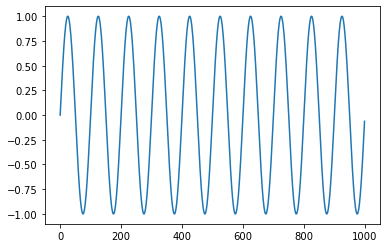

In [6]:
plt.plot(t,S)

### Model noise: Extracting values from a Gaussian distribution

In [7]:
# define noise with a standard deviation of a tenth of the amplitude of the sinusoidal function
noise = np.random.normal(0,scale = A/2, size = N)

In [8]:
# Add the noise to the original function 
Sn = S + noise

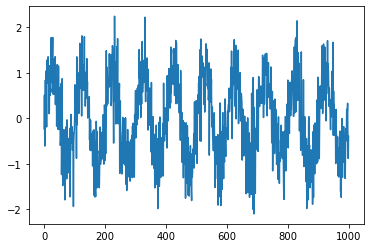

In [9]:
# plot the noise contaminated signal 
plt.plot(t,Sn)

# Wavelet Analysis for Sinodoide

In [10]:
# Setup 
dt = t[1]-t[0] #The difference in time which is euqal to 1
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.125  # this will do 8 sub-octaves per octave
s0 = 2*dt  # this says start at a scale of 24 months where 1 * 2 = 2 
j1 = -1  # this says do 7 powers-of-two with dj sub-octaves each ##### Why is this -1 here? (Ask Marcel)
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'MORLET'

In [11]:
print(dt)

1


In [12]:
# Wavelet transform:
wave, period, scale, coi = waveF.wavelet((Sn - Sn.mean())/np.var(Sn), dt, pad, dj, s0, j1, mother) #need time series (Sn), mean of time series, variance of time series,
# dt = time steps, Pad, sub octives, scale, some power of sub octives, and the wavelet name.

'''
inputs: 

(Sn - Sn.mean())/np.var(Sn): The input time series, normalized by subtracting its mean and dividing by its variance. This normalization is often done to ensure consistent scaling.

dt: The time step or sampling interval of the time series.

pad: Padding of the time series before the wavelet transform. Padding helps in dealing with edge effects.

dj: The scale resolution or spacing parameter for the wavelet transform.

s0: The smallest scale of the wavelet.

j1: The number of scales. The wavelet transform will be computed for j1 scales.

mother: The type of wavelet to be used in the transform (e.g., Morlet or Paul).


output:

wave: The wavelet transform of the input time series, representing how the signal's frequency content changes over time.

period: The vector of "Fourier" periods associated with the wavelet scales.

scale: The vector of wavelet scales.

coi: The cone of influence, which is a region of the wavelet transform where edge effects become important.'''


power = (np.abs(wave)) ** 2  # compute wavelet power spectrum

'''
power: This variable stores the square of the absolute values of the wavelet transform.
It represents the wavelet power spectrum, providing information about the distribution of power at different scales and times.
'''

global_ws = (np.sum(power, axis=1) / N)  # time-average over all times ###### What is the axis??

'''
outputs:

global_ws: This variable stores the time-averaged wavelet power spectrum over all times.

inputs:

np.sum(power, axis=1): This sums up the power spectrum along the time axis, giving the total power at each scale.

/ N: This normalizes the summed power by dividing it by the number of time points (N), giving the time-averaged power spectrum.'''

'\noutputs:\n\nglobal_ws: This variable stores the time-averaged wavelet power spectrum over all times.\n\ninputs:\n\nnp.sum(power, axis=1): This sums up the power spectrum along the time axis, giving the total power at each scale.\n\n/ N: This normalizes the summed power by dividing it by the number of time points (N), giving the time-averaged power spectrum.'

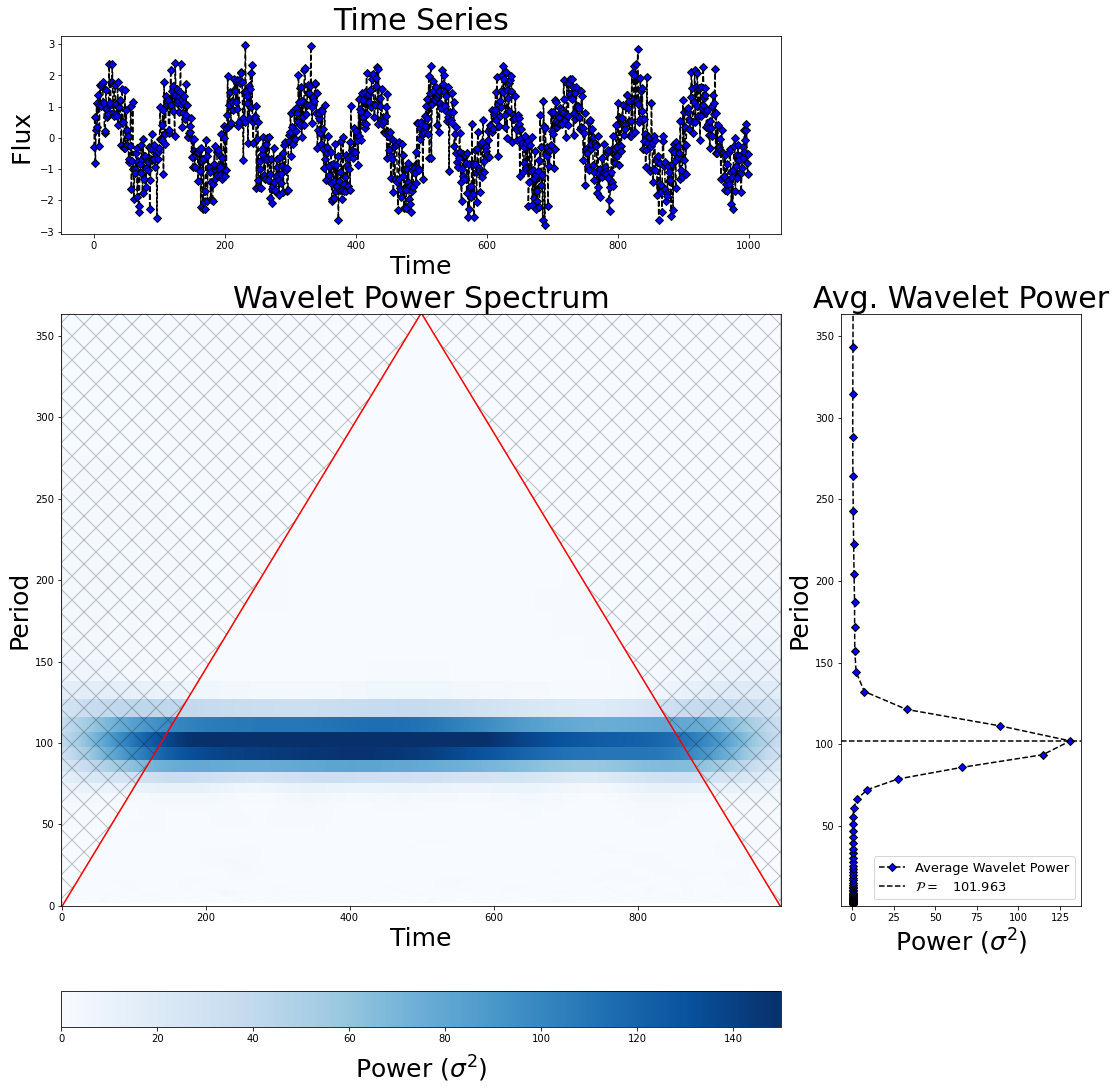

In [13]:
axd = plt.figure(figsize=(15, 15), constrained_layout=True).subplot_mosaic(
    """
    AAA.
    BBBC
    BBBC
    BBBC
    """)

fsize = 32
bwth = 10

sub1 = axd['A']
sub2 = axd['B']
sub3 = axd['C']

# Time series
sub1.plot(t, (Sn - Sn.mean()) / np.var(Sn), marker='D', color='black', linestyle='dashed', mfc='blue', label='Time Series')
sub1.set_title('Time Series', fontsize=30)
sub1.set_ylabel('Flux ', fontsize=25)
sub1.set_xlabel('Time', fontsize=25)

# Wavelet power spectrum
CS = sub2.pcolormesh(t, period, power, cmap='Blues', vmin=0, vmax=150)
sub2.plot(t, coi, 'r')  # cone of influence (The area's the signal is most reliable)
sub2.set_xlabel('Time', fontsize=25)
sub2.set_ylabel('Period', fontsize=25)
sub2.set_title('Wavelet Power Spectrum', fontsize=30)
sub2.fill_between(t, coi * 0 + period[-1], coi, facecolor="none",
                  edgecolor="#00000040", hatch='x')

sub2.set_ylim((0, np.max(coi)))
cbar = plt.colorbar(CS, location='bottom', ax=sub2)  # Pass ax=sub2
cbar.set_label('Power ($\sigma^2$)', labelpad=10, fontsize=25)

# Average wavelet power spectrum
sub3.plot(global_ws, period, marker='D', color='black', linestyle='dashed', mfc='blue', label='Average Wavelet Power')
sub3.axhline(y=period[np.argmax(global_ws)], xmin=0, xmax=1, color='k', linestyle='dashed',
             label='$\mathcal{P} =$' + "{:10.3f}".format(period[np.argmax(global_ws)]))
sub3.set_ylim((1, np.max(coi)))
sub3.set_title('Avg. Wavelet Power', fontsize=30)
sub3.set_xlabel('Power ($\sigma^2$)', fontsize=25)
sub3.set_ylabel('Period', fontsize=25)
legend = sub3.legend(fontsize=13, loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.show()


In [14]:
def power_law_model(a, f):
    return a[0] * f**a[1]

def colored_noise_model(a,f):
    return a[0] * f**a[1]  + a[2] 

def complex_noise_model(a,f): 
     """
    Power Law + Constant Power + Gaussian Enhancement Model
    Y = A_pl * f^a + A_cp + A_g * exp(-(f - f_g)^2 / (2 * sigma_g^2))
    log(Y) = log(A_pl * f^a + A_cp + A_g * exp(-(f - f_g)^2 / (2 * sigma_g^2)))
    log(Y) = a * log(f) + log(A_pl + A_cp + A_g * exp(-(f - f_g)^2 / (2 * sigma_g^2)))


    Parameters:
        frequencies: Frequency values[array]
        true_params: List containing model parameters [list]
              true_params[0]: Amplitude of power law
              true_params[1]: Power law index
              true_params[2]: Amplitude of constant power
              true_params[3]: Amplitude of Gaussian enhancement
              true_params[4]: Mean of Gaussian
              true_params[5]: Standard deviation of Gaussian

    Returns:
      Synthetic data following the power law + constant power + Gaussian enhancement model [array]
    """
    
     return a[0] * f**a[1]  + a[2] +  a[3] * ( 1 + f**2/( a[4]*a[5]**2 ) )**( -(a[4]+1) / 2)
def power_law_decay_model(a, f):
    """
    Power Law + Constant Power + Power Law Decay Model
    Y = A_pl * f^a + A_cp + A_pd * f^(-a)
    log(Y) = log(A_pl * f^a + A_cp + A_pd * f^(-a))
    log(Y) = a * log(f) + log(A_pl + A_cp + A_pd * f^(-a))

    Parameters:
        frequencies: Frequency values [array]
        true_params: List containing model parameters[list]
              true_params[0]: Amplitude of power law
              true_params[1]: Power law index
              true_params[2]: Amplitude of constant power
              true_params[3]: Amplitude of power law decay
              true_params[4]: Decay frequency of power law decay

    Returns:
      Synthetic data following the power law + constant power + power law decay model[array]
    """
    return a[0] * f**a[1] + a[2] + a[3] / (1 + (f / a[4])**2)

def power_law_decay_gaussian_model(a, f):
    """
    Power Law + Constant Power + Power Law Decay + Gaussian Enhancement Model
    Y = A_pl * f^a + A_cp + A_pd * f^(-a) + A_g * exp(-(f - f_g)^2 / (2 * sigma_g^2))
    log(Y) = log(A_pl * f^a + A_cp + A_pd * f^(-a) + A_g * exp(-(f - f_g)^2 / (2 * sigma_g^2)))
    log(Y) = a * log(f) + log(A_pl + A_cp + A_pd * f^(-a) + A_g * exp(-(f - f_g)^2 / (2 * sigma_g^2)))


    Parameters:
        frequencies: Frequency values [array]
        true_params: List containing model parameters[list]
              true_params[0]: Amplitude of power law
              true_params[1]: Power law index
              true_params[2]: Amplitude of constant power
              true_params[3]: Amplitude of power law decay
              true_params[4]: Decay frequency of power law decay
              true_params[5]: Amplitude of Gaussian enhancement
              true_params[6]: Mean of Gaussian
              true_params[7]: Standard deviation of Gaussian

    Returns:
      Synthetic data following the power law + constant power + power law decay + Gaussian enhancement model [array]
      
      ( 1 + f**2/( a[4]*a[5]**2 ) )**( -(a[4]+1) / 2)
    """
    return a[0] * f**a[1] + a[2] + a[3] / (1 + (f / a[4])**2) + a[5] * np.exp(-(f - a[6])**2 / (2 * a[7]**2))


In [15]:
def generate_sinosoid(frequencies, true_params, option=1):
    time = np.linspace(0, 10, 1000)  # Assuming time from 0 to 10 with 1000 data points
    
    if option == 1:
        oscillation = true_params[0] * np.sin(2 * np.pi * true_params[1] * time)  # Oscillation
        synthetic_data = oscillation
        
    if option == 2:
        oscillation = true_params[0] * np.cos(2 * np.pi * true_params[1] * time)  # Oscillation
        synthetic_data = oscillation
        
    return time, synthetic_data


def generate_gaussian(frequencies, true_params):
    # Generate Gaussian synthetic data
    amplitude, mean, sigma = true_params[:3]
    time = np.linspace(0, 1, len(frequencies))  # Assuming time is normalized to [0, 1]
    oscillation = amplitude * np.exp(-(time - mean)**2 / (2 * sigma**2))
    return time, oscillation

def generate_cosine(frequencies, true_params):
    # Generate Cosine synthetic data
    amplitude, frequency, phase = true_params[:3]
    time = np.linspace(0, 1, len(frequencies))  # Assuming time is normalized to [0, 1]
    oscillation = amplitude * np.cos(2 * np.pi * frequency * time + phase)
    return time, oscillation

def generate_exponential_decay(frequencies, true_params):
    # Generate Exponential Decay synthetic data
    amplitude, decay_rate = true_params[:2]
    time = np.linspace(0, 1, len(frequencies))  # Assuming time is normalized to [0, 1]
    oscillation = amplitude * np.exp(-decay_rate * time)
    return time, oscillation



In [16]:
def additional_components(frequencies, true_params, options=None):
    # Includes additional components (sinusoid, Gaussian, cosine, exponential decay) based on true_params
    additional_data = np.zeros_like(frequencies)

    if options is None:
        raise ValueError("Please provide a list of options for additional components.")

    for option in options:
        if option == 1:
            _, sinusoid_data = generate_sinosoid(frequencies, true_params)
            interpolator = interp1d(_, sinusoid_data, kind='linear', fill_value="extrapolate")
            additional_data += interpolator(frequencies)
        elif option == 2:
            _, gaussian_data = generate_gaussian(frequencies, true_params)
            interpolator = interp1d(_, gaussian_data, kind='linear', fill_value="extrapolate")
            additional_data += interpolator(frequencies)
        elif option == 3:
            _, cosine_data = generate_cosine(frequencies, true_params)
            interpolator = interp1d(_, cosine_data, kind='linear', fill_value="extrapolate")
            additional_data += interpolator(frequencies)
        elif option == 4:
            _, exponential_data = generate_exponential_decay(frequencies, true_params)
            interpolator = interp1d(_, exponential_data, kind='linear', fill_value="extrapolate")
            additional_data += interpolator(frequencies)
        else:
            raise ValueError(f"Invalid option {option}. Choose 1 for sinusoid, 2 for Gaussian, 3 for cosine, or 4 for exponential decay.")

    return additional_data

In [17]:


def generate_var_synthetic_data(frequencies, true_params, options=None, noise_params=None):
    
    # Generate synthetic data with known properties for the specified model
    if options is None:
        raise ValueError("Please provide a list of options for generating synthetic data.")
    
    # Synthetic data
    time, oscillation = generate_sinosoid(frequencies, true_params) if 1 in options else generate_empty(frequencies)
    
    # Combination of options
    for option in options[1:]:
        if option == 2:
            _, additional_data = generate_gaussian(frequencies, true_params)
        elif option == 3:
            _, additional_data = generate_cosine(frequencies, true_params)
        elif option == 4:
            _, additional_data = generate_exponential_decay(frequencies, true_params)
        else:
            raise ValueError(f"Invalid option {option}. Choose 1 for sinusoid, 2 for Gaussian, 3 for cosine, or 4 for exponential decay.")
        
        oscillation += additional_data
    
    # Added noise
    if noise_params is not None:
        noise = np.random.normal(0, noise_params[0], len(time))  # Gaussian noise
        oscillation += noise
    
    return time, oscillation


In [18]:
# Example usage:
frequencies = np.linspace(1, 1, 1000)
true_params = [3, -2, 6, 10, 4, 1]
options = [1, 2, 3]  # Combine sinusoid, Gaussian, and cosine
noise_params = [1e-3, 1e-5]  

time, synthetic_data = generate_var_synthetic_data(frequencies, true_params, options=options, noise_params=noise_params)

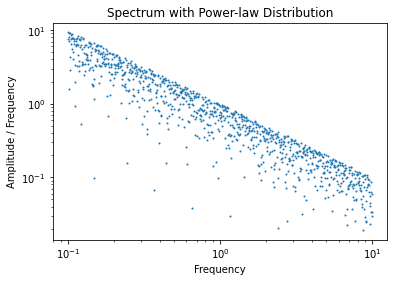

In [19]:
def generate_wavelet_spectrum(num_points, alpha, f_min, f_max):
    # Generate frequencies with a power-law distribution
    frequencies = np.geomspace(f_min, f_max, num_points)
    
    # Generate amplitudes with a power-law distribution
    amplitudes = np.random.power(alpha, size=num_points)
    
    # Create the wavelet spectrum
    spectrum = amplitudes / frequencies
    
    return frequencies, spectrum

# Parameters
num_points = 1000  # Number of points in the spectrum
alpha = 2.0       # Power-law exponent
f_min = 0.1       # Minimum frequency
f_max = 10.0      # Maximum frequency

# Generate synthetic wavelet spectrum
frequencies, spectrum = generate_wavelet_spectrum(num_points, alpha, f_min, f_max)

# Plot the synthetic wavelet spectrum
plt.loglog(frequencies, spectrum, marker='.', linestyle='None', markersize=2)
plt.title('Spectrum with Power-law Distribution')
plt.xlabel('Frequency')
plt.ylabel('Amplitude / Frequency')
plt.show()

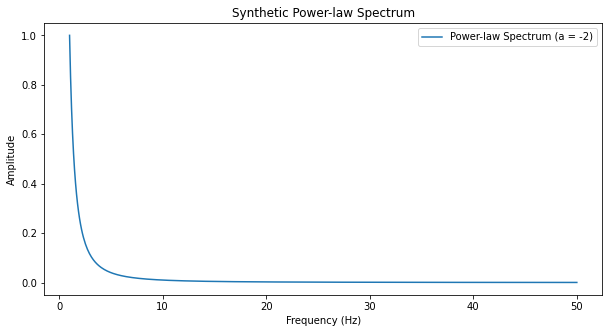

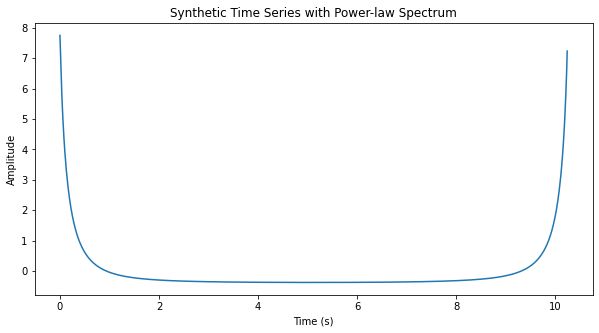

In [20]:
np.random.seed(42)

# Define parameters
num_points = 1024
sampling_rate = 100
duration = num_points / sampling_rate

# Generate frequencies based on a power-law distribution
alpha = -2
frequencies = np.linspace(1, sampling_rate / 2, num_points // 2)
power_law_spectrum = frequencies ** alpha

# Combine magnitude and phases to get the complex spectrum
complex_spectrum = power_law_spectrum

# Mirror the spectrum to create a symmetric spectrum
complex_spectrum_full = np.concatenate([complex_spectrum, complex_spectrum[::-1].conj()])

# Perform an inverse Fourier transform to obtain the time series
time_series = np.fft.ifft(complex_spectrum_full).real

# Normalize the time series to have zero mean and unit variance
time_series = (time_series - np.mean(time_series)) / np.std(time_series)

# Plot the power-law spectrum
plt.figure(figsize=(10, 5))
plt.plot(frequencies, power_law_spectrum, label=f'Power-law Spectrum (a = {alpha})')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Power-law Spectrum')
plt.show()

# Plot the generated time series
plt.figure(figsize=(10, 5))
t = np.linspace(0, duration, num_points)
plt.plot(t, time_series)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synthetic Time Series with Power-law Spectrum')
plt.show()


In [21]:
# Setup 
dt_TS = t[1]-t[0] #The difference in time which is euqal to 1
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.125  # this will do 8 sub-octaves per octave
s0 = 1*dt  # this says start at a scale of 24 months where 1 * 2 = 2 
j1 = -1  # this says do 7 powers-of-two with dj sub-octaves each ##### Why is this -1 here? (Ask Marcel)
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'MORLET'

In [22]:
print(np.shape((time_series - time_series.mean())/np.var(time_series)))
print(dt_TS)
print(np.median(1/frequencies))
print(np.std(1/frequencies))
print(np.mean(1/frequencies))
print(np.var(1/frequencies))

(1024,)
0.010009775171065494
0.03921582490902323
0.12024015586430241
0.08069295253484943
0.014457695082271738


In [23]:
# Wavelet transform:
wave, period, scale, coi = waveF.wavelet((time_series - time_series.mean())/np.var(time_series), dt_TS, pad, dj, s0, j1, mother) #need time series (Sn), mean of time series, variance of time series,
# dt = time steps, Pad, sub octives, scale, some power of sub octives, and the wavelet name.
power = (np.abs(wave)) ** 2  # compute wavelet power spectrum

global_ws = (np.sum(power, axis=1) / len(t))

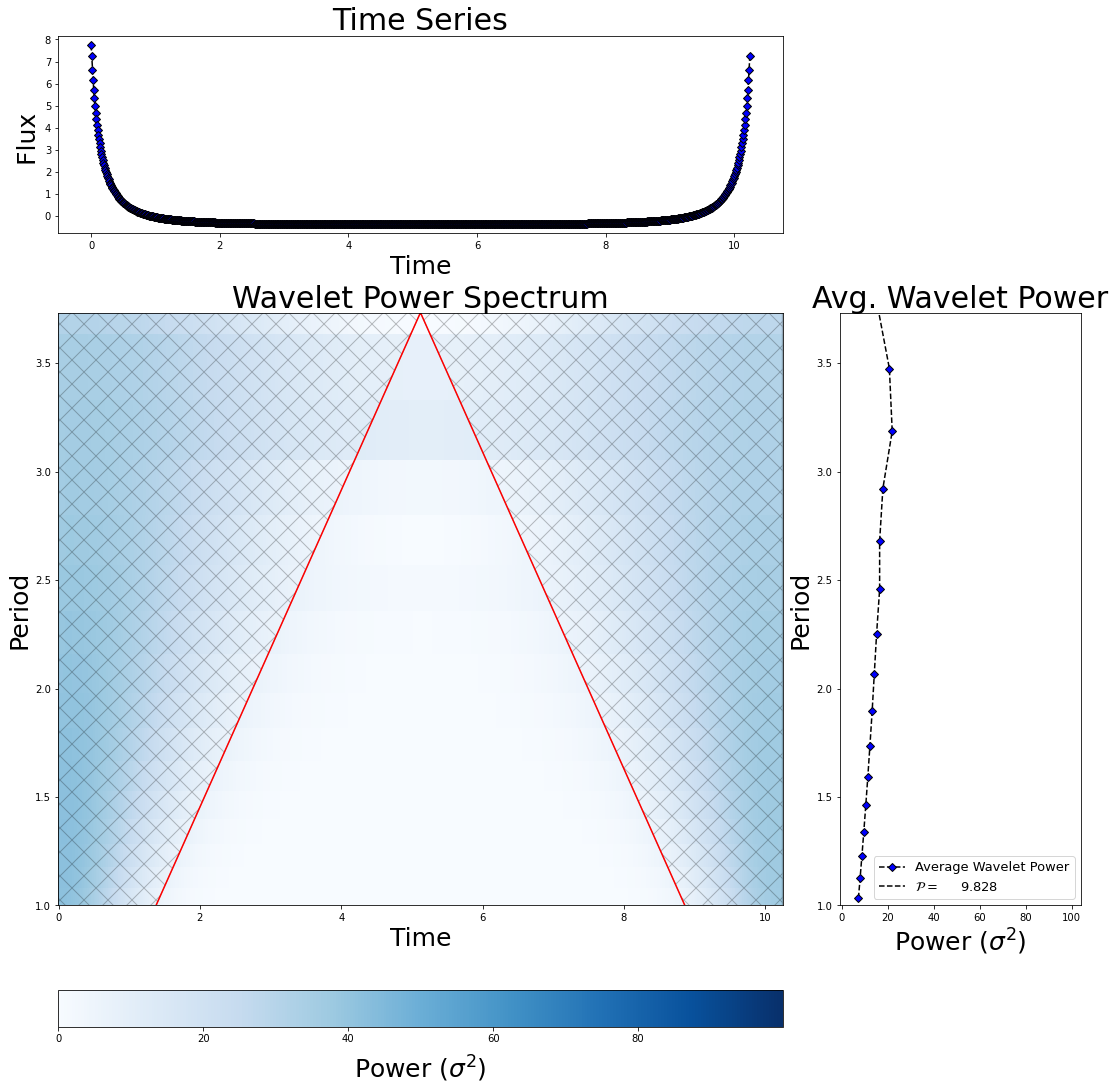

In [24]:
axd = plt.figure(figsize=(15, 15), constrained_layout=True).subplot_mosaic(
    """
    AAA.
    BBBC
    BBBC
    BBBC
    """)

fsize = 32
bwth = 10

sub1 = axd['A']
sub2 = axd['B']
sub3 = axd['C']

# Time series
sub1.plot(t, (time_series - time_series.mean()) / np.var(time_series), marker='D', color='black', linestyle='dashed', mfc='blue', label='Time Series')
sub1.set_title('Time Series', fontsize=30)
sub1.set_ylabel('Flux ', fontsize=25)
sub1.set_xlabel('Time', fontsize=25)

# Wavelet power spectrum
CS = sub2.pcolormesh(t, period, power, cmap='Blues')
sub2.plot(t, coi, 'r')  # cone of influence (The area's the signal is most reliable)
sub2.set_xlabel('Time', fontsize=25)
sub2.set_ylabel('Period', fontsize=25)
sub2.set_title('Wavelet Power Spectrum', fontsize=30)
sub2.fill_between(t, coi * 0 + period[-1], coi, facecolor="none",
                  edgecolor="#00000040", hatch='x')

sub2.set_ylim((1, np.max(coi)))
cbar = plt.colorbar(CS, location='bottom', ax=sub2)  # Pass ax=sub2
cbar.set_label('Power ($\sigma^2$)', labelpad=10, fontsize=25)

# Average wavelet power spectrum
sub3.plot(global_ws, period, marker='D', color='black', linestyle='dashed', mfc='blue', label='Average Wavelet Power')
sub3.axhline(y=period[np.argmax(global_ws)], xmin=0, xmax=1, color='k', linestyle='dashed',
             label='$\mathcal{P} =$' + "{:10.3f}".format(period[np.argmax(global_ws)]))
sub3.set_ylim((1, np.max(coi)))
sub3.set_title('Avg. Wavelet Power', fontsize=30)
sub3.set_xlabel('Power ($\sigma^2$)', fontsize=25)
sub3.set_ylabel('Period', fontsize=25)
legend = sub3.legend(fontsize=13, loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.show()


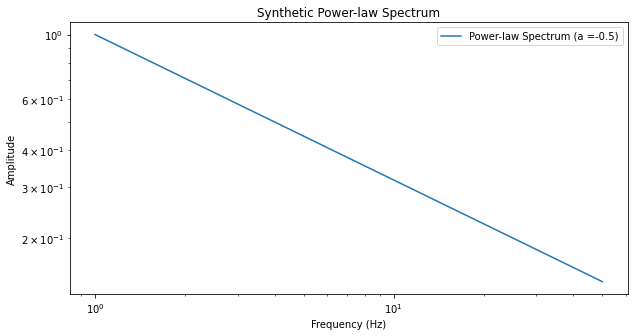

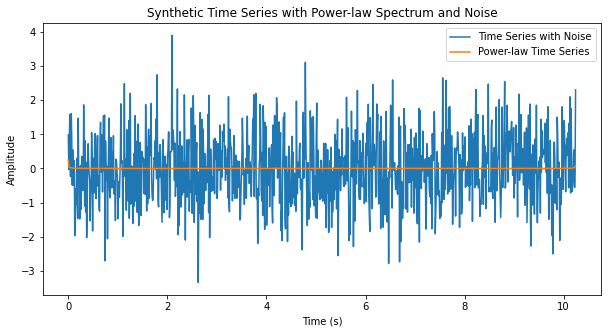

In [25]:
np.random.seed(42)

# Define parameters
num_points = 1024
sampling_rate = 100
duration = num_points / sampling_rate

# Generate frequencies based on a power-law distribution
alpha = -.5
frequencies = np.linspace(1, sampling_rate / 2, num_points // 2)
power_law_spectrum = frequencies ** alpha

# Combine magnitude and phases to get the complex spectrum
complex_spectrum = power_law_spectrum

# Mirror the spectrum to create a symmetric spectrum
complex_spectrum_full = np.concatenate([complex_spectrum, complex_spectrum[::-1].conj()])

# Perform an inverse Fourier transform to obtain the time series
time_series_power_law = np.fft.ifft(complex_spectrum_full).real

# Add noise to the time series
noise_level = 0.5
noise = noise_level * np.random.randn(num_points)
time_series_with_noise = time_series_power_law + noise

# Normalize the time series to have zero mean and unit variance
time_series_with_noise = (time_series_with_noise - np.mean(time_series_with_noise)) / np.std(time_series_with_noise)

# Plot the power-law spectrum
plt.figure(figsize=(10, 5))
plt.loglog(frequencies, power_law_spectrum, label=f'Power-law Spectrum (a ={alpha})')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Power-law Spectrum')
plt.show()

# Plot the generated time series with noise
plt.figure(figsize=(10, 5))
t = np.linspace(0, duration, num_points)
plt.plot(t, time_series_with_noise, label='Time Series with Noise')
plt.plot(t, time_series_power_law, label='Power-law Time Series')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Time Series with Power-law Spectrum and Noise')
plt.show()

In [26]:
# Setup 
dt_TSn = t[1]-t[0] #The difference in time which is euqal to 1
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.125  # this will do 8 sub-octaves per octave
s0 = 1*dt  # this says start at a scale of 24 months where 1 * 2 = 2 
j1 = -1  # this says do 7 powers-of-two with dj sub-octaves each ##### Why is this -1 here? (Ask Marcel)
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'MORLET'

In [27]:
wave, period, scale, coi = waveF.wavelet((time_series_with_noise - time_series_with_noise.mean())/np.var(time_series_with_noise), dt_TSn, pad, dj, s0, j1, mother)

power = (np.abs(wave)) ** 2  # compute wavelet power spectrum

global_ws = (np.sum(power, axis=1) / len(t))

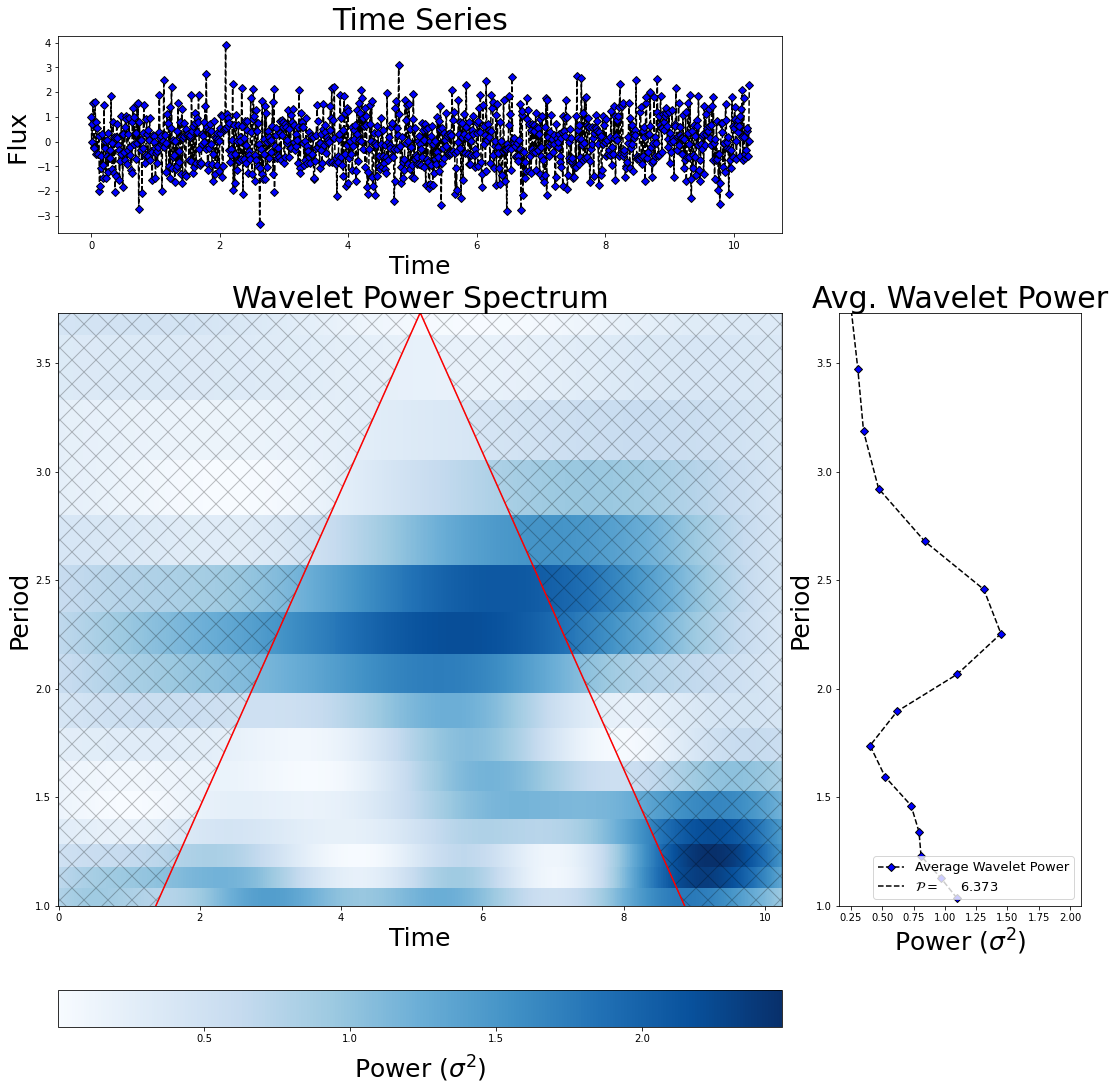

In [28]:
axd = plt.figure(figsize=(15, 15), constrained_layout=True).subplot_mosaic(
    """
    AAA.
    BBBC
    BBBC
    BBBC
    """)

fsize = 32
bwth = 10

sub1 = axd['A']
sub2 = axd['B']
sub3 = axd['C']

# Time series
sub1.plot(t, (time_series_with_noise - time_series_with_noise.mean()) / np.var(time_series_with_noise), marker='D', color='black', linestyle='dashed', mfc='blue', label='Time Series')
sub1.set_title('Time Series', fontsize=30)
sub1.set_ylabel('Flux ', fontsize=25)
sub1.set_xlabel('Time', fontsize=25)

# Wavelet power spectrum
CS = sub2.pcolormesh(t, period, power, cmap='Blues')
sub2.plot(t, coi, 'r')  # cone of influence (The area's the signal is most reliable)
sub2.set_xlabel('Time', fontsize=25)
sub2.set_ylabel('Period', fontsize=25)
sub2.set_title('Wavelet Power Spectrum', fontsize=30)
sub2.fill_between(t, coi * 0 + period[-1], coi, facecolor="none",
                  edgecolor="#00000040", hatch='x')

sub2.set_ylim((1, np.max(coi)))
cbar = plt.colorbar(CS, location='bottom', ax=sub2)  # Pass ax=sub2
cbar.set_label('Power ($\sigma^2$)', labelpad=10, fontsize=25)

# Average wavelet power spectrum
sub3.plot(global_ws, period, marker='D', color='black', linestyle='dashed', mfc='blue', label='Average Wavelet Power')
sub3.axhline(y=period[np.argmax(global_ws)], xmin=0, xmax=1, color='k', linestyle='dashed',
             label='$\mathcal{P} =$' + "{:10.3f}".format(period[np.argmax(global_ws)]))
sub3.set_ylim((1, np.max(coi)))
sub3.set_title('Avg. Wavelet Power', fontsize=30)
sub3.set_xlabel('Power ($\sigma^2$)', fontsize=25)
sub3.set_ylabel('Period', fontsize=25)
legend = sub3.legend(fontsize=13, loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.show()


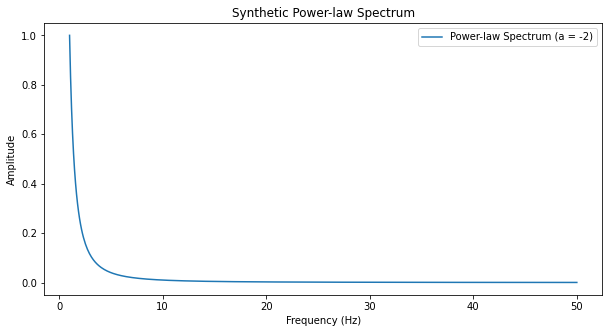

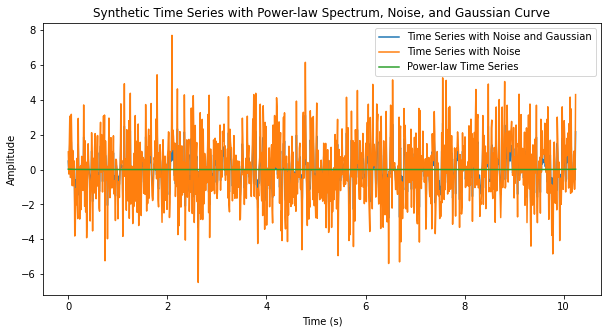

In [29]:
np.random.seed(42)

# Define parameters
num_points = 1024
sampling_rate = 100
duration = num_points / sampling_rate

# Generate frequencies based on a power-law distribution
alpha = -2
frequencies = np.linspace(1, sampling_rate / 2, num_points // 2)
power_law_spectrum = frequencies ** alpha

# Combine magnitude and phases to get the complex spectrum
complex_spectrum = power_law_spectrum

# Mirror the spectrum to create a symmetric spectrum
complex_spectrum_full = np.concatenate([complex_spectrum, complex_spectrum[::-1].conj()])

# Perform an inverse Fourier transform to obtain the time series
time_series_power_law = np.fft.ifft(complex_spectrum_full).real

# Add noise to the time series
noise_level = 2 
noise = noise_level * np.random.randn(num_points)
time_series_with_noise = time_series_power_law + noise

# Add a Gaussian curve to the time series
gaussian_mean = -5 
gaussian_std = 0.1  
gaussian_curve = np.exp(-(t - gaussian_mean)**2 / (2 * gaussian_std**2))

# Combine the time series with noise and the Gaussian curve
time_series_with_gaussian = time_series_with_noise + gaussian_curve

# Normalize the final time series to have zero mean and unit variance
time_series_with_gaussian = (time_series_with_gaussian - np.mean(time_series_with_gaussian)) / np.std(time_series_with_gaussian)

# Plot the power-law spectrum
plt.figure(figsize=(10, 5))
plt.plot(frequencies, power_law_spectrum, label=f'Power-law Spectrum (a = {alpha})')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Power-law Spectrum')
plt.show()

# Plot the generated time series with noise and Gaussian curve
plt.figure(figsize=(10, 5))
plt.plot(t, time_series_with_gaussian, label='Time Series with Noise and Gaussian')
plt.plot(t, time_series_with_noise, label='Time Series with Noise')
plt.plot(t, time_series_power_law, label='Power-law Time Series')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Time Series with Power-law Spectrum, Noise, and Gaussian Curve')
plt.show()

In [30]:
# Setup 
dt_TSn_G = t[1]-t[0] #The difference in time which is euqal to 1
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.125  # this will do 8 sub-octaves per octave
s0 = 1*dt  # this says start at a scale of 24 months where 1 * 2 = 2 
j1 = -1  # this says do 7 powers-of-two with dj sub-octaves each ##### Why is this -1 here? (Ask Marcel)
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'MORLET'

In [31]:
wave, period, scale, coi = waveF.wavelet((time_series_with_gaussian - time_series_with_gaussian.mean())/np.var(time_series_with_gaussian), dt_TSn_G, pad, dj, s0, j1, mother)

power = (np.abs(wave)) ** 2  # compute wavelet power spectrum

global_ws = (np.sum(power, axis=1) / len(t))

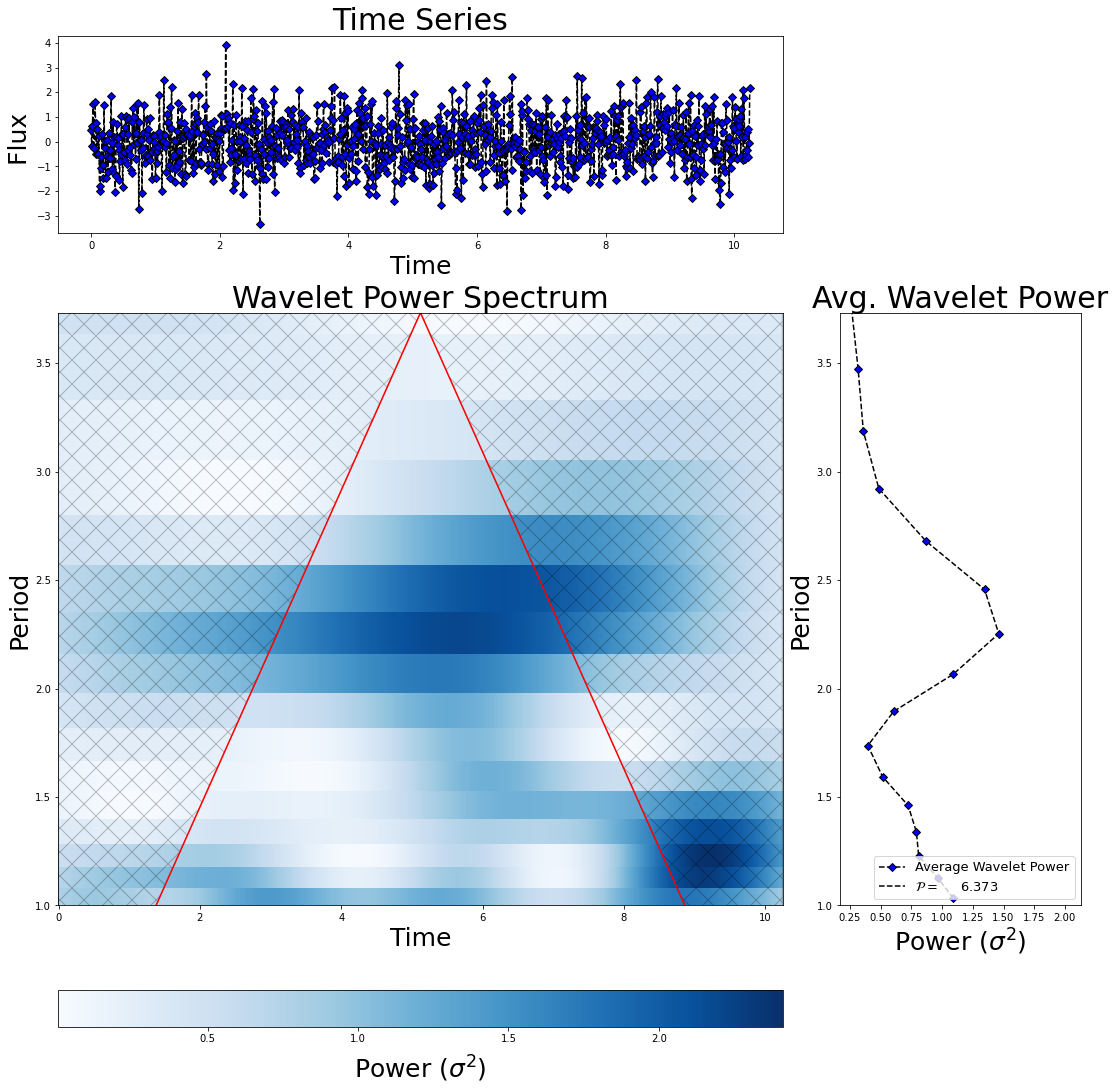

In [32]:
axd = plt.figure(figsize=(15, 15), constrained_layout=True).subplot_mosaic(
    """
    AAA.
    BBBC
    BBBC
    BBBC
    """)

fsize = 32
bwth = 10

sub1 = axd['A']
sub2 = axd['B']
sub3 = axd['C']

# Time series
sub1.plot(t, (time_series_with_gaussian - time_series_with_gaussian.mean()) / np.var(time_series_with_gaussian), marker='D', color='black', linestyle='dashed', mfc='blue', label='Time Series')
sub1.set_title('Time Series', fontsize=30)
sub1.set_ylabel('Flux ', fontsize=25)
sub1.set_xlabel('Time', fontsize=25)

# Wavelet power spectrum
CS = sub2.pcolormesh(t, period, power, cmap='Blues')
sub2.plot(t, coi, 'r')  # cone of influence (The area's the signal is most reliable)
sub2.set_xlabel('Time', fontsize=25)
sub2.set_ylabel('Period', fontsize=25)
sub2.set_title('Wavelet Power Spectrum', fontsize=30)
sub2.fill_between(t, coi * 0 + period[-1], coi, facecolor="none",
                  edgecolor="#00000040", hatch='x')

sub2.set_ylim((1, np.max(coi)))
cbar = plt.colorbar(CS, location='bottom', ax=sub2)  # Pass ax=sub2
cbar.set_label('Power ($\sigma^2$)', labelpad=10, fontsize=25)

# Average wavelet power spectrum
sub3.plot(global_ws, period, marker='D', color='black', linestyle='dashed', mfc='blue', label='Average Wavelet Power')
sub3.axhline(y=period[np.argmax(global_ws)], xmin=0, xmax=1, color='k', linestyle='dashed',
             label='$\mathcal{P} =$' + "{:10.3f}".format(period[np.argmax(global_ws)]))
sub3.set_ylim((1, np.max(coi)))
sub3.set_title('Avg. Wavelet Power', fontsize=30)
sub3.set_xlabel('Power ($\sigma^2$)', fontsize=25)
sub3.set_ylabel('Period', fontsize=25)
legend = sub3.legend(fontsize=13, loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.show()


In [ ]:
np.random.seed(42)

# Define parameters
num_points = 1024
sampling_rate = 100
duration = num_points / sampling_rate

# Generate frequencies based on a power-law distribution
alpha = -2
frequencies = np.linspace(1, sampling_rate / 2, num_points // 2)
power_law_spectrum = frequencies ** alpha

# Combine magnitude and phases to get the complex spectrum
complex_spectrum = power_law_spectrum

# Mirror the spectrum to create a symmetric spectrum
complex_spectrum_full = np.concatenate([complex_spectrum, complex_spectrum[::-1].conj()])

# Perform an inverse Fourier transform to obtain the time series
time_series_power_law = np.fft.ifft(complex_spectrum_full).real

# Add noise to the time series
noise_level = 0.2  
noise = noise_level * np.random.randn(num_points)
time_series_with_noise = time_series_power_law + noise

# Add a sinusoidal component to the time series
sinusoidal_frequency = 5  
sinusoidal_amplitude = 0.5  
sinusoidal_curve = sinusoidal_amplitude * np.sin(2 * np.pi * sinusoidal_frequency * t)

# Combine the time series with noise and the sinusoidal component
time_series_with_sinusoid = time_series_with_noise + sinusoidal_curve

# Normalize the final time series to have zero mean and unit variance
time_series_with_sinusoid = (time_series_with_sinusoid - np.mean(time_series_with_sinusoid)) / np.std(time_series_with_sinusoid)

# Plot the power-law spectrum
plt.figure(figsize=(10, 5))
plt.plot(frequencies, power_law_spectrum, label=f'Power-law Spectrum (a = {alpha})')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Power-law Spectrum')
plt.show()

# Plot the generated time series with noise and sinusoidal component
plt.figure(figsize=(10, 5))
plt.plot(t, time_series_with_sinusoid, label='Time Series with Noise and Sinusoidal Component')
plt.plot(t, time_series_with_noise, label='Time Series with Noise')
plt.plot(t, time_series_power_law, label='Power-law Time Series')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Time Series with Power-law Spectrum, Noise, and Sinusoidal Component')
plt.show()

In [ ]:
# Setup 
dt_TSn_S = t[1]-t[0] #The difference in time which is euqal to 1
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.125  # this will do 8 sub-octaves per octave
s0 = 1*dt  # this says start at a scale of 24 months where 1 * 2 = 2 
j1 = -1  # this says do 7 powers-of-two with dj sub-octaves each ##### Why is this -1 here? (Ask Marcel)
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'MORLET'

In [ ]:
wave, period, scale, coi = waveF.wavelet((time_series_with_sinusoid - time_series_with_sinusoid.mean())/np.var(time_series_with_sinusoid), dt_TSn_S, pad, dj, s0, j1, mother)

power = (np.abs(wave)) ** 2  # compute wavelet power spectrum

global_ws = (np.sum(power, axis=1) / len(t))

In [ ]:
axd = plt.figure(figsize=(15, 15), constrained_layout=True).subplot_mosaic(
    """
    AAA.
    BBBC
    BBBC
    BBBC
    """)

fsize = 32
bwth = 10

sub1 = axd['A']
sub2 = axd['B']
sub3 = axd['C']

# Time series
sub1.plot(t, (time_series_with_sinusoid - time_series_with_sinusoid.mean()) / np.var(time_series_with_sinusoid), marker='D', color='black', linestyle='dashed', mfc='blue', label='Time Series')
sub1.set_title('Time Series', fontsize=30)
sub1.set_ylabel('Flux ', fontsize=25)
sub1.set_xlabel('Time', fontsize=25)

# Wavelet power spectrum
CS = sub2.pcolormesh(t, period, power, cmap='Blues')
sub2.plot(t, coi, 'r')  # cone of influence (The area's the signal is most reliable)
sub2.set_xlabel('Time', fontsize=25)
sub2.set_ylabel('Period', fontsize=25)
sub2.set_title('Wavelet Power Spectrum', fontsize=30)
sub2.fill_between(t, coi * 0 + period[-1], coi, facecolor="none",
                  edgecolor="#00000040", hatch='x')

sub2.set_ylim((1, np.max(coi)))
cbar = plt.colorbar(CS, location='bottom', ax=sub2)  # Pass ax=sub2
cbar.set_label('Power ($\sigma^2$)', labelpad=10, fontsize=25)

# Average wavelet power spectrum
sub3.plot(global_ws, period, marker='D', color='black', linestyle='dashed', mfc='blue', label='Average Wavelet Power')
sub3.axhline(y=period[np.argmax(global_ws)], xmin=0, xmax=1, color='k', linestyle='dashed',
             label='$\mathcal{P} =$' + "{:10.3f}".format(period[np.argmax(global_ws)]))
sub3.set_ylim((1, np.max(coi)))
sub3.set_title('Avg. Wavelet Power', fontsize=30)
sub3.set_xlabel('Power ($\sigma^2$)', fontsize=25)
sub3.set_ylabel('Period', fontsize=25)
legend = sub3.legend(fontsize=13, loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.show()


In [ ]:

np.random.seed(42)

# Define parameters
num_points = 1024
sampling_rate = 100
duration = num_points / sampling_rate

# Generate frequencies based on a power-law distribution
alpha = -2
frequencies = np.linspace(1, sampling_rate / 2, num_points // 2)
power_law_spectrum = frequencies ** alpha

# Combine magnitude and phases to get the complex spectrum
complex_spectrum = power_law_spectrum

# Mirror the spectrum to create a symmetric spectrum
complex_spectrum_full = np.concatenate([complex_spectrum, complex_spectrum[::-1].conj()])

# Perform an inverse Fourier transform to obtain the time series
time_series_power_law = np.fft.ifft(complex_spectrum_full).real

# Add noise to the time series
noise_level = 0.2 
noise = noise_level * np.random.randn(num_points)
time_series_with_noise = time_series_power_law + noise

# Add a sinusoidal component to the time series
sinusoidal_frequency = 5 
sinusoidal_amplitude = 0.5  
sinusoidal_curve = sinusoidal_amplitude * np.sin(2 * np.pi * sinusoidal_frequency * t)

# Add a Gaussian curve to the time series
gaussian_mean = 0.5 
gaussian_std = 0.1 
gaussian_curve = np.exp(-(t - gaussian_mean)**2 / (2 * gaussian_std**2))

# Combine the time series with noise, sinusoidal component, and Gaussian curve
time_series_with_sinusoid_and_gaussian = time_series_with_noise + sinusoidal_curve + gaussian_curve

# Normalize the final time series to have zero mean and unit variance
time_series_with_sinusoid_and_gaussian = (time_series_with_sinusoid_and_gaussian - np.mean(time_series_with_sinusoid_and_gaussian)) / np.std(time_series_with_sinusoid_and_gaussian)

# Plot the power-law spectrum
plt.figure(figsize=(10, 5))
plt.plot(frequencies, power_law_spectrum, label=f'Power-law Spectrum (a = {alpha})')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Power-law Spectrum')
plt.show()

# Plot the generated time series with noise, sinusoidal component, and Gaussian curve
plt.figure(figsize=(10, 5))
plt.plot(t, time_series_with_sinusoid_and_gaussian, label='Time Series with Noise, Sinusoidal, and Gaussian')
plt.plot(t, time_series_with_noise, label='Time Series with Noise')
plt.plot(t, time_series_power_law, label='Power-law Time Series')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Time Series with Power-law Spectrum, Noise, Sinusoidal, and Gaussian')
plt.show()

In [ ]:
# Setup 
dt_TSn_SG = t[1]-t[0] #The difference in time which is euqal to 1
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.125  # this will do 8 sub-octaves per octave
s0 = 1*dt  # this says start at a scale of 24 months where 1 * 2 = 2 
j1 = -1  # this says do 7 powers-of-two with dj sub-octaves each ##### Why is this -1 here? (Ask Marcel)
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'MORLET'

In [ ]:
wave, period, scale, coi = waveF.wavelet((time_series_with_sinusoid_and_gaussian - time_series_with_sinusoid_and_gaussian.mean())/np.var(time_series_with_sinusoid_and_gaussian), dt_TSn_SG, pad, dj, s0, j1, mother)

power = (np.abs(wave)) ** 2  # compute wavelet power spectrum

global_ws = (np.sum(power, axis=1) / len(t))

In [ ]:
axd = plt.figure(figsize=(15, 15), constrained_layout=True).subplot_mosaic(
    """
    AAA.
    BBBC
    BBBC
    BBBC
    """)

fsize = 32
bwth = 10

sub1 = axd['A']
sub2 = axd['B']
sub3 = axd['C']

# Time series
sub1.plot(t, (time_series_with_sinusoid_and_gaussian - time_series_with_sinusoid_and_gaussian.mean()) / np.var(time_series_with_sinusoid_and_gaussian), marker='D', color='black', linestyle='dashed', mfc='blue', label='Time Series')
sub1.set_title('Time Series', fontsize=30)
sub1.set_ylabel('Flux ', fontsize=25)
sub1.set_xlabel('Time', fontsize=25)

# Wavelet power spectrum
CS = sub2.pcolormesh(t, period, power, cmap='Blues')
sub2.plot(t, coi, 'r')  # cone of influence (The area's the signal is most reliable)
sub2.set_xlabel('Time', fontsize=25)
sub2.set_ylabel('Period', fontsize=25)
sub2.set_title('Wavelet Power Spectrum', fontsize=30)
sub2.fill_between(t, coi * 0 + period[-1], coi, facecolor="none",
                  edgecolor="#00000040", hatch='x')

sub2.set_ylim((1, np.max(coi)))
cbar = plt.colorbar(CS, location='bottom', ax=sub2)  # Pass ax=sub2
cbar.set_label('Power ($\sigma^2$)', labelpad=10, fontsize=25)

# Average wavelet power spectrum
sub3.plot(global_ws, period, marker='D', color='black', linestyle='dashed', mfc='blue', label='Average Wavelet Power')
sub3.axhline(y=period[np.argmax(global_ws)], xmin=0, xmax=1, color='k', linestyle='dashed',
             label='$\mathcal{P} =$' + "{:10.3f}".format(period[np.argmax(global_ws)]))
sub3.set_ylim((1, np.max(coi)))
sub3.set_title('Avg. Wavelet Power', fontsize=30)
sub3.set_xlabel('Power ($\sigma^2$)', fontsize=25)
sub3.set_ylabel('Period', fontsize=25)
legend = sub3.legend(fontsize=13, loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.show()


In [ ]:
# Now with an added wavelet spectrum

np.random.seed(42)

# Define parameters
num_points = 1024  # Number of points in the time series
sampling_rate = 100  # Sampling rate in Hz
duration = num_points / sampling_rate  # Duration of the time series

# Generate frequencies based on a power-law distribution
alpha = -2 # Power-law exponent
frequencies = np.linspace(1, sampling_rate / 2, num_points // 2)
power_law_spectrum = frequencies ** alpha

# Generate random phases
phases = np.random.rand(num_points // 2) * 2 * np.pi

# Combine magnitude and phases to get the complex spectrum
complex_spectrum = power_law_spectrum * np.exp(1j * phases)

# Mirror the spectrum to create a symmetric spectrum
complex_spectrum_full = np.concatenate([complex_spectrum, complex_spectrum[::-1].conj()])

# Perform an inverse Fourier transform to obtain the time series
time_series = np.fft.ifft(complex_spectrum_full).real

# Normalize the time series to have zero mean and unit variance
time_series_wavelet = (time_series - np.mean(time_series)) / np.std(time_series)

# Plot the power-law spectrum
plt.figure(figsize=(10, 5))
plt.plot(frequencies, power_law_spectrum, label=f'Power-law Spectrum (alpha = {alpha})')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Wavelet Spectrum with Power-law Distribution')
plt.show()

# Plot the generated time series
plt.figure(figsize=(10, 5))
t = np.linspace(0, duration, num_points)
plt.plot(t, time_series_wavelet)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synthetic Time Series with Power-law Wavelet Spectrum')
plt.show()

In [ ]:
# Setup 
dt_TS_W = t[1]-t[0] #The difference in time which is euqal to 1
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.125  # this will do 8 sub-octaves per octave
s0 = 1*dt  # this says start at a scale of 24 months where 1 * 2 = 2 
j1 = -1  # this says do 7 powers-of-two with dj sub-octaves each ##### Why is this -1 here? (Ask Marcel)
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'MORLET'

In [ ]:
wave, period, scale, coi = waveF.wavelet((time_series_wavelet - time_series_wavelet.mean())/np.var(time_series_wavelet), dt_TS_W, pad, dj, s0, j1, mother)

power = (np.abs(wave)) ** 2  # compute wavelet power spectrum

global_ws = (np.sum(power, axis=1) / len(t))

In [ ]:
axd = plt.figure(figsize=(15, 15), constrained_layout=True).subplot_mosaic(
    """
    AAA.
    BBBC
    BBBC
    BBBC
    """)

fsize = 32
bwth = 10

sub1 = axd['A']
sub2 = axd['B']
sub3 = axd['C']

# Time series
sub1.plot(t, (time_series_wavelet - time_series_wavelet.mean()) / np.var(time_series_wavelet), marker='D', color='black', linestyle='dashed', mfc='blue', label='Time Series')
sub1.set_title('Time Series', fontsize=30)
sub1.set_ylabel('Flux ', fontsize=25)
sub1.set_xlabel('Time', fontsize=25)

# Wavelet power spectrum
CS = sub2.pcolormesh(t, period, power, cmap='Blues')
sub2.plot(t, coi, 'r')  # cone of influence (The area's the signal is most reliable)
sub2.set_xlabel('Time', fontsize=25)
sub2.set_ylabel('Period', fontsize=25)
sub2.set_title('Wavelet Power Spectrum', fontsize=30)
sub2.fill_between(t, coi * 0 + period[-1], coi, facecolor="none",
                  edgecolor="#00000040", hatch='x')

sub2.set_ylim((1, np.max(coi)))
cbar = plt.colorbar(CS, location='bottom', ax=sub2)  # Pass ax=sub2
cbar.set_label('Power ($\sigma^2$)', labelpad=10, fontsize=25)

# Average wavelet power spectrum
sub3.plot(global_ws, period, marker='D', color='black', linestyle='dashed', mfc='blue', label='Average Wavelet Power')
sub3.axhline(y=period[np.argmax(global_ws)], color='k', linestyle='dashed',
             label='$\mathcal{P} =$' + "{:10.3f}".format(period[np.argmax(global_ws)]))
sub3.set_ylim((1, np.max(coi)))
sub3.set_title('Avg. Wavelet Power', fontsize=30)
sub3.set_xlabel('Power ($\sigma^2$)', fontsize=25)
sub3.set_ylabel('Period', fontsize=25)
legend = sub3.legend(fontsize=13, loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.show()


In [ ]:
# Now with an added wavelet spectrum

np.random.seed(42)

# Define parameters
num_points = 1024  # Number of points in the time series
sampling_rate = 100  # Sampling rate in Hz
duration = num_points / sampling_rate  # Duration of the time series

# Generate frequencies based on a power-law distribution
alpha = -2  # Power-law exponent
frequencies = np.linspace(1, sampling_rate / 2, num_points // 2)
power_law_spectrum = frequencies ** alpha

# Generate random phases
phases = np.random.rand(num_points // 2) * 2 * np.pi

# Combine magnitude and phases to get the complex spectrum
complex_spectrum = power_law_spectrum * np.exp(1j * phases)

# Mirror the spectrum to create a symmetric spectrum
complex_spectrum_full = np.concatenate([complex_spectrum, complex_spectrum[::-1].conj()])

# Perform an inverse Fourier transform to obtain the time series
time_series = np.fft.ifft(complex_spectrum_full).real

# Add noise to the time series
noise_level = .2
noise = noise_level * np.random.randn(num_points)
time_series_noise_W = time_series + noise

# Add a sinusoidal component to the time series
sinusoidal_frequency = 5 
sinusoidal_amplitude = .5  
sinusoidal_curve = (sinusoidal_amplitude) * np.sin(2 * np.pi * sinusoidal_frequency * t) + noise

# Add a cos component to the time series
cos_frequency = 2.5 
cos_amplitude = .5 
cos_curve = (cos_amplitude) * np.cos(2 * np.pi * cos_frequency * t) + noise


# Add a Gaussian curve to the time series
gaussian_mean = 0.5
gaussian_std = .1 
gaussian_curve = np.exp(-(t - gaussian_mean)**2 / (2 * gaussian_std**2))+ noise

# Combine the time series with noise, sinusoidal component, and Gaussian curve
time_series_SGC_W = time_series_noise_W + sinusoidal_curve + gaussian_curve + cos_curve

# Normalize the final time series to have zero mean and unit variance
time_series_SGC_W = (time_series_SGC_W - np.mean(time_series_SGC_W)) / np.std(time_series_SGC_W)

# Plot the power-law spectrum
plt.figure(figsize=(10, 5))
plt.loglog(frequencies, power_law_spectrum, label=f'Power-law Spectrum (a = {alpha})')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Power-law Spectrum')
plt.show()

# Plot the generated time series with noise, sinusoidal component, and Gaussian curve
plt.figure(figsize=(10, 5))
plt.plot(t, time_series_SGC_W, label='Time Series with Noise, Sinusoidal, Gaussian, and Wavelet')
plt.plot(t, time_series_with_noise, label='Time Series with Noise')
plt.plot(t, time_series_power_law, label='Power-law Time Series')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Time Series with Power-law Spectrum, Noise, Sinusoidal, and Gaussian')
plt.show()

In [ ]:
# Setup 
dt_TSn_SGW = t[1]-t[0] #The difference in time which is euqal to 1
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.125  # this will do 8 sub-octaves per octave
s0 = 1*dt  # this says start at a scale of 24 months where 1 * 2 = 2 
j1 = -1  # this says do 7 powers-of-two with dj sub-octaves each ##### Why is this -1 here? (Ask Marcel)
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'MORLET'

In [ ]:
wave, period, scale, coi = waveF.wavelet((time_series_SGC_W - time_series_SGC_W.mean())/np.var(time_series_SGC_W), dt_TSn_SGW, pad, dj, s0, j1, mother)

power = (np.abs(wave)) ** 2  # compute wavelet power spectrum

global_ws = (np.sum(power, axis=1) / len(t))

In [ ]:
axd = plt.figure(figsize=(15, 15), constrained_layout=True).subplot_mosaic(
    """
    AAA.
    BBBC
    BBBC
    BBBC
    """)

fsize = 32
bwth = 10

sub1 = axd['A']
sub2 = axd['B']
sub3 = axd['C']

# Time series
sub1.plot(t, (time_series_SGC_W - time_series_SGC_W.mean()) / np.var(time_series_SGC_W), marker='D', color='black', linestyle='dashed', mfc='blue', label='Time Series')
sub1.set_title('Time Series', fontsize=30)
sub1.set_ylabel('Flux ', fontsize=25)
sub1.set_xlabel('Time', fontsize=25)

# Wavelet power spectrum
CS = sub2.pcolormesh(t, period, power, cmap='Blues')
sub2.plot(t, coi, 'r')  # cone of influence (The area's the signal is most reliable)
sub2.set_xlabel('Time', fontsize=25)
sub2.set_ylabel('Period', fontsize=25)
sub2.set_title('Wavelet Power Spectrum', fontsize=30)
sub2.fill_between(t, coi * 0 + period[-1], coi, facecolor="none",
                  edgecolor="#00000040", hatch='x')

sub2.set_ylim((1, np.max(coi)))
cbar = plt.colorbar(CS, location='bottom', ax=sub2)  # Pass ax=sub2
cbar.set_label('Power ($\sigma^2$)', labelpad=10, fontsize=25)

# Average wavelet power spectrum
sub3.plot(global_ws, period, marker='D', color='black', linestyle='dashed', mfc='blue', label='Average Wavelet Power')
sub3.axhline(y=period[np.argmax(global_ws)], color='k', linestyle='dashed',
             label='$\mathcal{P} =$' + "{:10.3f}".format(period[np.argmax(global_ws)]))
sub3.set_ylim((1, np.max(coi)))
sub3.set_title('Avg. Wavelet Power', fontsize=30)
sub3.set_xlabel('Power ($\sigma^2$)', fontsize=25)
sub3.set_ylabel('Period', fontsize=25)
legend = sub3.legend(fontsize=13, loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.show()


In [ ]:
def plot_wavelet_analysis(time_series, t, dt, pad, dj, s0, j1, mother):
    """
    Plot the time series, wavelet power spectrum, and average wavelet power spectrum.

    Parameters:
        time_series: Time series data [array]
        t: Time values [array]
        dt: Time step
        pad: Pad the time series with zeroes (recommended)
        dj: Sub-octaves per octave
        s0: Start at a scale
        j1: Powers-of-two with dj sub-octaves
        mother: Mother wavelet name
    """
    # Wavelet transform
    wave, period, scale, coi = waveF.wavelet((time_series - time_series.mean()) / np.var(time_series), dt, pad, dj, s0, j1, mother)

    power = (np.abs(wave)) ** 2  # Compute wavelet power spectrum

    global_ws = (np.sum(power, axis=1) / len(t))

    # Plotting
    axd = plt.figure(figsize=(15, 15), constrained_layout=True).subplot_mosaic(
        """
        AAA.
        BBBC
        BBBC
        BBBC
        """)

    fsize = 32
    bwth = 10

    sub1 = axd['A']
    sub2 = axd['B']
    sub3 = axd['C']

    # Time series
    sub1.plot(t, (time_series - time_series.mean()) / np.var(time_series), marker='D', color='black', linestyle='dashed', mfc='blue', label='Time Series')
    sub1.set_title('Time Series', fontsize=30)
    sub1.set_ylabel('Flux ', fontsize=25)
    sub1.set_xlabel('Time', fontsize=25)

    # Wavelet power spectrum
    CS = sub2.pcolormesh(t, period, power, cmap='Blues')
    sub2.plot(t, coi, 'r')  # Cone of influence (The area's the signal is most reliable)
    sub2.set_xlabel('Time', fontsize=25)
    sub2.set_ylabel('Period', fontsize=25)
    sub2.set_title('Wavelet Power Spectrum', fontsize=30)
    sub2.fill_between(t, coi * 0 + period[-1], coi, facecolor="none",
                      edgecolor="#00000040", hatch='x')

    sub2.set_ylim((1, np.max(coi)))
    cbar = plt.colorbar(CS, location='bottom', ax=sub2)  # Pass ax=sub2
    cbar.set_label('Power ($\sigma^2$)', labelpad=10, fontsize=25)

    # Average wavelet power spectrum
    sub3.plot(global_ws, period, marker='D', color='black', linestyle='dashed', mfc='blue', label='Average Wavelet Power')
    sub3.axhline(y=period[np.argmax(global_ws)], color='k', linestyle='dashed',
                 label='$\mathcal{P} =$' + "{:10.3f}".format(period[np.argmax(global_ws)]))
    sub3.set_ylim((1, np.max(coi)))
    sub3.set_title('Avg. Wavelet Power', fontsize=30)
    sub3.set_xlabel('Power ($\sigma^2$)', fontsize=25)
    sub3.set_ylabel('Period', fontsize=25)
    legend = sub3.legend(fontsize=13, loc='lower right', bbox_to_anchor=(1.0, 0.0))

    plt.show()

# Example 
dt_TSn_SGW = t[1] - t[0]
pad = 1
dj = 0.125
s0 = 1 * dt
j1 = -1
lag1 = 0.72
mother = 'MORLET'

plot_wavelet_analysis(time_series_SGC_W, t, dt_TSn_SGW, pad, dj, s0, j1, mother)

### More Examples

In [ ]:
np.random.seed(42)

# Define parameters
num_points = 1024  # Number of points in the time series
sampling_rate = 100  # Sampling rate in Hz
duration = num_points / sampling_rate  # Duration of the time series

alpha = -2  # Power-law exponent
colored_noise_params = [1, alpha, 3]  # Parameters for colored_noise_model

frequencies = np.linspace(1, sampling_rate / 2, num_points // 2)
colored_spectrum_model = colored_noise_model(colored_noise_params, frequencies)

# Generate random phases
phases = np.random.rand(num_points // 2) * 2 * np.pi

# Combine magnitude and phases to get the complex spectrum
colored_spectrum = colored_spectrum_model * np.exp(1j * phases)

# Mirror the spectrum to create a symmetric spectrum
colored_spectrum_full = np.concatenate([colored_spectrum, colored_spectrum[::-1].conj()])

# Perform an inverse Fourier transform to obtain the time series
time_series = np.fft.ifft(colored_spectrum_full).real

# Add noise to the time series
noise_level = 0.2
noise = noise_level * np.random.randn(num_points)
time_series_noise_W = time_series + noise

# Add a sinusoidal component to the time series
sinusoidal_frequency = 5
sinusoidal_amplitude = 0.5
sinusoidal_curve = (sinusoidal_amplitude) * np.sin(2 * np.pi * sinusoidal_frequency * t) + noise

# Add a cos component to the time series
cos_frequency = 2.5
cos_amplitude = 0.5
cos_curve = (cos_amplitude) * np.cos(2 * np.pi * cos_frequency * t) + noise

# Add a Gaussian curve to the time series
gaussian_mean = 0.5
gaussian_std = 0.1
gaussian_curve = np.exp(-(t - gaussian_mean)**2 / (2 * gaussian_std**2)) + noise

# Combine the time series with noise, sinusoidal component, and Gaussian curve
time_series_color_SGC_W = time_series_noise_W + sinusoidal_curve + gaussian_curve + cos_curve

# Normalize the final time series to have zero mean and unit variance
time_series_color_SGC_W = (time_series_color_SGC_W - np.mean(time_series_color_SGC_W)) / np.std(time_series_color_SGC_W)

# Plot the power-law spectrum using colored_noise_model
plt.figure(figsize=(10, 5))
plt.loglog(frequencies, colored_spectrum_model, label=f'Colored Noise Spectrum (a = {colored_noise_params})')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Colored Noise Spectrum')
plt.show()

# Plot the generated time series with noise, sinusoidal component, and Gaussian curve
plt.figure(figsize=(10, 5))
plt.plot(t, time_series_color_SGC_W, label='Time Series with Noise, Sinusoidal, Gaussian, and Colored Noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Time Series with Colored Noise Spectrum, Noise, Sinusoidal, and Gaussian')
plt.show()


In [ ]:
dt = t[1] - t[0]
pad = 1
dj = 0.125
s0 = 1 * dt
j1 = -1
lag1 = 0.72
mother = 'MORLET'

plot_wavelet_analysis(time_series_color_SGC_W, t, dt, pad, dj, s0, j1, mother)

In [ ]:
np.random.seed(42)

# Define parameters
num_points = 1024  # Number of points in the time series
sampling_rate = 100  # Sampling rate in Hz
duration = num_points / sampling_rate  # Duration of the time series

# Parameters for complex_noise_model
complex_noise_params = [1, -2, 0.1, 0.5, 5, 2]

frequencies = np.linspace(1, sampling_rate / 2, num_points // 2)
complex_noise_spectrum = complex_noise_model(complex_noise_params, frequencies)

# Generate random phases
phases = np.random.rand(num_points // 2) * 2 * np.pi

# Combine magnitude and phases to get the complex spectrum
complex_spectrum = complex_noise_spectrum * np.exp(1j * phases)

# Mirror the spectrum to create a symmetric spectrum
complex_spectrum_full = np.concatenate([complex_spectrum, complex_spectrum[::-1].conj()])

# Perform an inverse Fourier transform to obtain the time series
time_series = np.fft.ifft(complex_spectrum_full).real

# Add noise to the time series
noise_level = 0.2
noise = noise_level * np.random.randn(num_points)
time_series_noise_W = time_series + noise

# Add a sinusoidal component to the time series
sinusoidal_frequency = 5
sinusoidal_amplitude = 0.5
sinusoidal_curve = (sinusoidal_amplitude) * np.sin(2 * np.pi * sinusoidal_frequency * t) + noise

# Add a cos component to the time series
cos_frequency = 2.5
cos_amplitude = 0.5
cos_curve = (cos_amplitude) * np.cos(2 * np.pi * cos_frequency * t) + noise

# Add a Gaussian curve to the time series
gaussian_mean = 0.5
gaussian_std = 0.1
gaussian_curve = np.exp(-(t - gaussian_mean)**2 / (2 * gaussian_std**2)) + noise

# Combine the time series with noise, sinusoidal component, and Gaussian curve
time_series_comp_SGC_W = time_series_noise_W + sinusoidal_curve + gaussian_curve + cos_curve

# Normalize the final time series to have zero mean and unit variance
time_series_comp_SGC_W = (time_series_comp_SGC_W - np.mean(time_series_comp_SGC_W)) / np.std(time_series_comp_SGC_W)

# Plot the complex noise spectrum using complex_noise_model
plt.figure(figsize=(10, 5))
plt.loglog(frequencies, np.abs(complex_noise_spectrum), label='Complex Noise Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Complex Noise Spectrum')
plt.show()

# Plot the generated time series with noise, sinusoidal component, and Gaussian curve
plt.figure(figsize=(10, 5))
plt.plot(t, time_series_comp_SGC_W, label='Time Series with Noise, Sinusoidal, Gaussian, and Complex Noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Time Series with Complex Noise Spectrum, Noise, Sinusoidal, and Gaussian')
plt.show()

In [ ]:
dt = t[1] - t[0]
pad = 1
dj = 0.125
s0 = 1 * dt
j1 = -1
lag1 = 0.72
mother = 'MORLET'

plot_wavelet_analysis(time_series_comp_SGC_W, t, dt, pad, dj, s0, j1, mother)

In [ ]:
np.random.seed(42)

# Define parameters
num_points = 1024  # Number of points in the time series
sampling_rate = 100  # Sampling rate in Hz
duration = num_points / sampling_rate  # Duration of the time series

# Parameters for power_law_decay_model
power_law_decay_params = [1, -2, 0.1, 5, 5]

frequencies = np.linspace(1, sampling_rate / 2, num_points // 2)
power_law_decay_spectrum = power_law_decay_model(power_law_decay_params, frequencies)

# Generate random phases
phases = np.random.rand(num_points // 2) * 2 * np.pi

# Combine magnitude and phases to get the complex spectrum
complex_spectrum = power_law_decay_spectrum * np.exp(1j * phases)

# Mirror the spectrum to create a symmetric spectrum
complex_spectrum_full = np.concatenate([complex_spectrum, complex_spectrum[::-1].conj()])

# Perform an inverse Fourier transform to obtain the time series
time_series = np.fft.ifft(complex_spectrum_full).real

# Add noise to the time series
noise_level = 0.2
noise = noise_level * np.random.randn(num_points)
time_series_noise_W = time_series + noise

# Add a sinusoidal component to the time series
sinusoidal_frequency = 5
sinusoidal_amplitude = 0.5
sinusoidal_curve = (sinusoidal_amplitude) * np.sin(2 * np.pi * sinusoidal_frequency * t) + noise

# Add a cos component to the time series
cos_frequency = 2.5
cos_amplitude = 0.5
cos_curve = (cos_amplitude) * np.cos(2 * np.pi * cos_frequency * t) + noise

# Add a Gaussian curve to the time series
gaussian_mean = 0.5
gaussian_std = 0.1
gaussian_curve = np.exp(-(t - gaussian_mean)**2 / (2 * gaussian_std**2)) + noise

# Combine the time series with noise, sinusoidal component, and Gaussian curve
time_series_SGC_W = time_series_noise_W + sinusoidal_curve + gaussian_curve + cos_curve

# Normalize the final time series to have zero mean and unit variance
time_series_decay_SGC_W = (time_series_SGC_W - np.mean(time_series_SGC_W)) / np.std(time_series_SGC_W)

# Plot the power law decay spectrum using power_law_decay_model
plt.figure(figsize=(10, 5))
plt.loglog(frequencies, power_law_decay_spectrum, label='Power Law Decay Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Power Law Decay Spectrum')
plt.show()

# Plot the generated time series with noise, sinusoidal component, and Gaussian curve
plt.figure(figsize=(10, 5))
plt.plot(t, time_series_decay_SGC_W, label='Time Series with Noise, Sinusoidal, Gaussian, and Power Law Decay')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Time Series with Power Law Decay Spectrum, Noise, Sinusoidal, and Gaussian')
plt.show()

In [ ]:
dt = t[1] - t[0]
pad = 1
dj = 0.125
s0 = 1 * dt
j1 = -1
lag1 = 0.72
mother = 'MORLET'

plot_wavelet_analysis(time_series_decay_SGC_W, t, dt, pad, dj, s0, j1, mother)

In [ ]:
np.random.seed(42)

# Define parameters
num_points = 1024  # Number of points in the time series
sampling_rate = 100  # Sampling rate in Hz
duration = num_points / sampling_rate  # Duration of the time series

# Parameters for power_law_decay_gaussian_model
power_law_decay_gaussian_params = [1, -2, 0.1, 0.5, 0.5, 2, 5, 2]

frequencies = np.linspace(1, sampling_rate / 2, num_points // 2)
power_law_decay_gaussian_spectrum = power_law_decay_gaussian_model(power_law_decay_gaussian_params, frequencies)

# Generate random phases
phases = np.random.rand(num_points // 2) * 2 * np.pi

# Combine magnitude and phases to get the complex spectrum
complex_spectrum = power_law_decay_gaussian_spectrum * np.exp(1j * phases)

# Mirror the spectrum to create a symmetric spectrum
complex_spectrum_full = np.concatenate([complex_spectrum, complex_spectrum[::-1].conj()])

# Perform an inverse Fourier transform to obtain the time series
time_series = np.fft.ifft(complex_spectrum_full).real

# Add noise to the time series
noise_level = 0.2
noise = noise_level * np.random.randn(num_points)
time_series_noise_W = time_series + noise

# Add a sinusoidal component to the time series
sinusoidal_frequency = 5
sinusoidal_amplitude = 0.5
sinusoidal_curve = (sinusoidal_amplitude) * np.sin(2 * np.pi * sinusoidal_frequency * t) + noise

# Add a cos component to the time series
#cos_frequency = 2.5
#cos_amplitude = 0.5
#cos_curve = (cos_amplitude) * np.cos(2 * np.pi * cos_frequency * t) + noise

# Add a Gaussian curve to the time series
gaussian_mean = 0.5
gaussian_std = 0.1
gaussian_curve = np.exp(-(t - gaussian_mean)**2 / (2 * gaussian_std**2)) + noise

# Combine the time series with noise, sinusoidal component, and Gaussian curve
time_series_SGC_W = time_series_noise_W + sinusoidal_curve + gaussian_curve + cos_curve

# Normalize the final time series to have zero mean and unit variance
time_series_decayG_SGC_W = (time_series_SGC_W - np.mean(time_series_SGC_W)) / np.std(time_series_SGC_W)

# Plot the power law decay Gaussian spectrum using power_law_decay_gaussian_model
plt.figure(figsize=(10, 5))
plt.plot(frequencies, power_law_decay_gaussian_spectrum, label='Power Law Decay Gaussian Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Power Law Decay Gaussian Spectrum')
plt.show()

# Plot the generated time series with noise, sinusoidal component, and Gaussian curve
plt.figure(figsize=(10, 5))
plt.plot(t, time_series_decayG_SGC_W, label='Time Series with Noise, Sinusoidal, Gaussian, and Power Law Decay Gaussian')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Synthetic Time Series with Power Law Decay Gaussian Spectrum, Noise, Sinusoidal, and Gaussian')
plt.show()

In [ ]:
dt = t[1] - t[0]
pad = 1
dj = 0.125
s0 = 1 * dt
j1 = -1
lag1 = 0.72
mother = 'MORLET'

plot_wavelet_analysis(time_series_decayG_SGC_W, t, dt, pad, dj, s0, j1, mother)